In [ ]:
import torch as th
import torchvision.transforms as T
import requests
from PIL import Image, ImageDraw, ImageFont

In [ ]:
model = th.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [ ]:
url = input()

https://ak.picdn.net/offset/photos/57f41c09ba6f6bfc1a4919d3/medium/photo.jpg


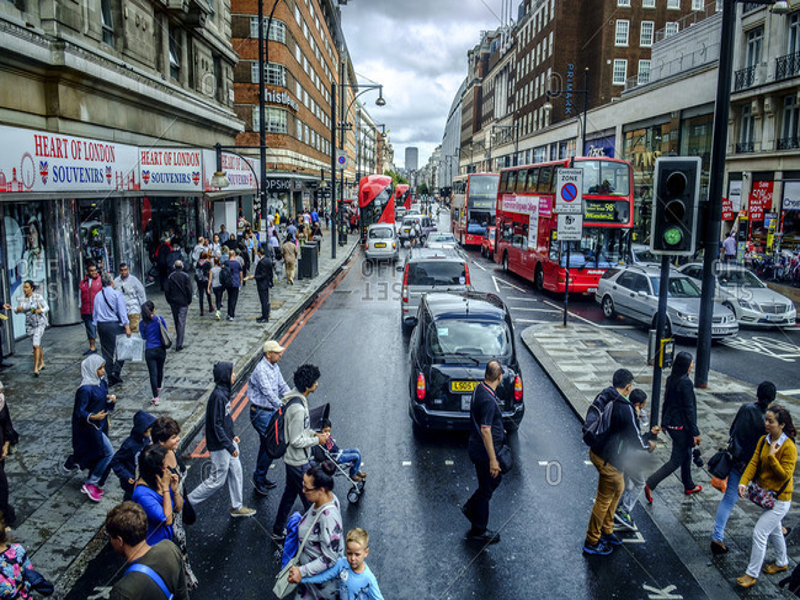

In [ ]:
img = Image.open(requests.get(url, stream=True).raw).resize((800,600)).convert('RGB')
img

In [ ]:
img_tens = transform(img).unsqueeze(0)

In [ ]:
with th.no_grad():
  output = model(img_tens)

In [ ]:
im2 = img.copy()
drw = ImageDraw.Draw(im2)
pred_logits=output['pred_logits'][0][:, :len(CLASSES)]
pred_boxes=output['pred_boxes'][0]

max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(15)

pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]
pred_logits.shape

torch.Size([15, 91])

In [ ]:
for logits, box in zip(pred_logits, pred_boxes):
  cls = logits.argmax()
  if cls >= len(CLASSES):
    continue
  label = CLASSES[cls]
  print(label)
  box = box.cpu() * th.Tensor([800, 600, 800, 600])
  x, y, w, h = box
  x0, x1 = x-w//2, x+w//2
  y0, y1 = y-h//2, y+h//2
  drw.rectangle([x0, y0, x1, y1], outline='red', width=5)
  drw.text((x, y), label, fill='white')

person
person
traffic light
car
person
person
person
car
person
person
backpack
backpack
person
person
person


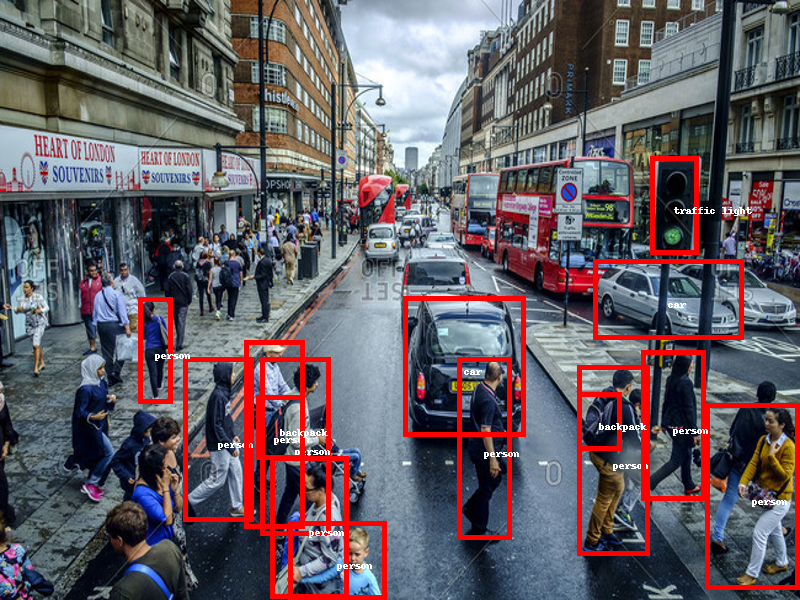

In [ ]:
im2